In [1]:
using DataFrames, CSV, Plots,Lathe,GLM,Statistics,StatsPlots,MLBase, StatsBase
#using Measures,  RDatasets, PlotlyJS , Plots,ScikitLearn,StatisticsRDatasets
df = DataFrame(CSV.File("sonar.all-data",header=0))
first(df,5)
m,n = size(df)
for i in 1:n
    actFiled = "Column"*string(i)
    rempField ="C_"*string(i)
    df = rename(df, actFiled => rempField)
end

# 1. Objetivo

Predecir si algún objeto se puede clasificar como mina o roca a partir de las distintas señales de respuesta percibidas por un sonar desde distintos ángulos. Para este fin se evaluan distintos algoritmos de aprendizaje.

# 2. Datos

El archivo  _sonar.all-data_ contiene 208 registros. Cada dato se encuentra representado con 60 valores numéricos y un valor que contine la etiqueta __R__ para roca o __M__ para mina.

|MINES|ROCKS|TOTAL|
|:-------:|:-------:|:------:|
| 111 | 97 | 208 |

Los valores numéricos se encuentran en un rango de 0 a 1 y representan la energía en una frecuencia particular. 

>Gorman, R. P., and Sejnowski, T. J. (1988). “Analysis of Hidden Units in a Layered Network Trained to Classify Sonar Targets” in Neural Networks, Vol. 1, pp. 75-89. [Artículo](https://www.semanticscholar.org/paper/Analysis-of-hidden-units-in-a-layered-network-to-Gorman-Sejnowski/7bdaefdd9954b75fdf305135b27105214c8eac66)


In [2]:
a = describe(df)
print(a)

61×7 DataFrame
 Row │ variable  mean        min     median   max     nmissing  eltype   
     │ Symbol    Union…      Any     Union…   Any     Int64     DataType 
─────┼───────────────────────────────────────────────────────────────────
   1 │ C_1       0.0291639   0.0015  0.0228   0.1371         0  Float64
   2 │ C_2       0.0384365   0.0006  0.0308   0.2339         0  Float64
   3 │ C_3       0.0438322   0.0015  0.0343   0.3059         0  Float64
   4 │ C_4       0.0538923   0.0058  0.04405  0.4264         0  Float64
   5 │ C_5       0.0752024   0.0067  0.0625   0.401          0  Float64
   6 │ C_6       0.10457     0.0102  0.09215  0.3823         0  Float64
   7 │ C_7       0.121747    0.0033  0.10695  0.3729         0  Float64
   8 │ C_8       0.134799    0.0055  0.1121   0.459          0  Float64
   9 │ C_9       0.178003    0.0075  0.15225  0.6828         0  Float64
  10 │ C_10      0.208259    0.0113  0.1824   0.7106         0  Float64
  11 │ C_11      0.236013    0.0289  0.2248

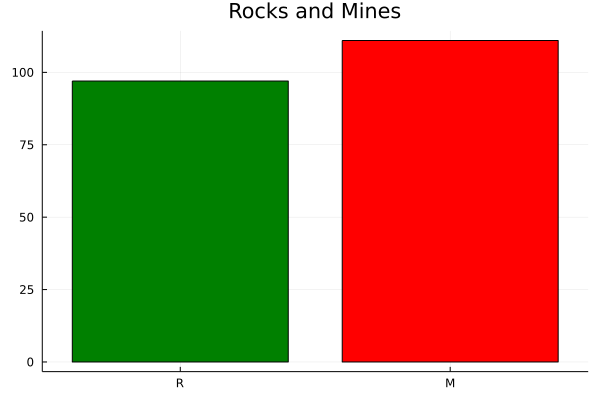

In [4]:
using Statistics
#@df df plot(cols(1:2) , group=:C_61 ,legend=nothing )
MineNames = unique(df.C_61);
MineFreqs = [sn => sum(df.C_61 .== sn) for sn in MineNames];
datamap = Dict(MineFreqs);
bar((x -> datamap[x]).(MineNames), xticks=(1:2, MineNames), label = false , title = "Rocks and Mines", color = ["green","red"])

En las siguientes imagenes podemos darnos una idea de como se correlacionan las distintas variables. Primero calculamos las correlaciones para cada tipo de objeto es decir, rocas o minas.

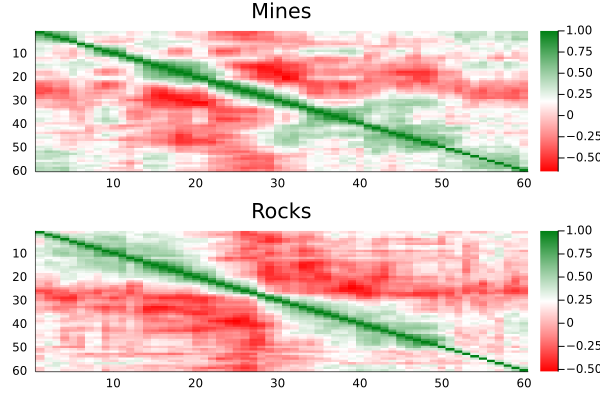

In [5]:
R = groupby(df, :C_61)[1];
M = groupby(df, :C_61)[2];
p1 = heatmap(cor(Matrix(M[!,Not(r"_61")])),yflip=true, color = :redgreensplit, title = "Mines" );
p2 = heatmap(cor(Matrix(R[!,Not(r"_61")])),yflip=true,color = :redgreensplit, title = "Rocks");
plot(p1, p2, layout = (2,1), legend = false)

Vemos que existe una correlaciòn entre las varibales vecinas para ambos tipos de obejtos a clasificar. Vemos si este comportamiento persiste para la muestra en general calculando la matriz de correlaciónm sin discriminar entre los dos tipos de objetos.

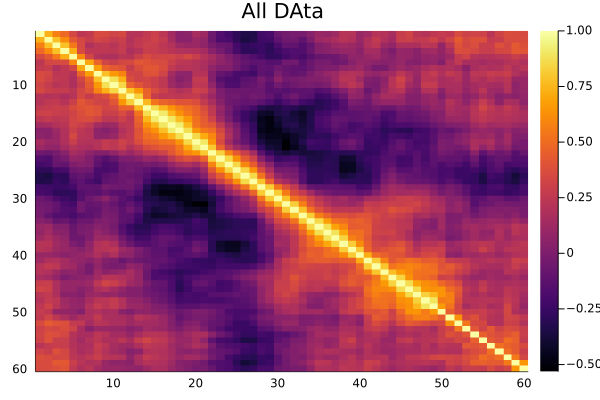

In [6]:
heatmap(cor(Matrix(df[!,Not(r"_61")])),yflip=true, title = "All DAta")

Es claro que existe una correlaciòn fuerte entre las varables vecinas, por lo que es necesario estimar _cuantitativamente_ cuales varibles podemos escoger sin que exista redundancia en la información de alguno de los modelos.

Para esto se calucla el indice de correlación para cada par de caracteríticas $(c_{i},c_{j})$ así, comprobamos cuantitativamtne lo que se presenta en las imagenes anteriores.


Para esto se porpone usar prueba de hipótesis. La Hipótesis Nula $H_{0}$ es  $Cor(c_{i},c_{j})=0$  con un nivel de significanci $\alpha = 0.05$. Si $\alpha > p-value$ podemos entonces  decir que no hay evidencia estadística para rechazar la hipótesis que la correlación entre las dos variables es cero. Con lo cual asumimos que no hay correlación entre ellas. A continuación, se enlistan las columnas para las cuales se cumple que no existe correlación apartir de la muestra.

In [7]:
using HypothesisTests
#=
A = df[!,Not("C_61")]
for f in names(A)
    A = A[!,Not(f)]
    print(size(A))
end
=#
A = df[!,Not("C_61")]
for f in names(A)
    print("----------------------------\n")
    B = A[!,Not(f)]
    for t in names(B)
        d = CorrelationTest(A[!,f] , B[!,t]);
        outcome = if pvalue(d)  > 0.05 "No hay evidencia estadística para rechazar H0" else "Rechaza H0" end
        if outcome == "No hay evidencia estadística para rechazar H0" print(f*" "*t*"\n") else   end
        #print(f*" "*t*'\n')        
    end
    A = B
end



----------------------------
C_1 C_18
C_1 C_19
C_1 C_21
C_1 C_22
C_1 C_30
C_1 C_31
C_1 C_32
C_1 C_33
C_1 C_34
C_1 C_35
C_1 C_36
C_1 C_37
C_1 C_40
C_1 C_41
----------------------------
C_2 C_18
C_2 C_19
C_2 C_20
C_2 C_21
C_2 C_22
C_2 C_30
C_2 C_31
C_2 C_32
C_2 C_33
C_2 C_34
C_2 C_35
C_2 C_36
C_2 C_40
C_2 C_44
----------------------------
C_3 C_18
C_3 C_19
C_3 C_20
C_3 C_21
C_3 C_22
C_3 C_23
C_3 C_24
C_3 C_31
C_3 C_32
C_3 C_34
C_3 C_35
C_3 C_36
C_3 C_37
C_3 C_38
C_3 C_39
C_3 C_40
C_3 C_43
C_3 C_44
C_3 C_50
----------------------------
C_4 C_22
C_4 C_23
C_4 C_24
C_4 C_34
C_4 C_35
C_4 C_36
C_4 C_37
C_4 C_38
C_4 C_39
C_4 C_40
C_4 C_43
C_4 C_44
C_4 C_45
C_4 C_46
C_4 C_47
C_4 C_48
C_4 C_49
C_4 C_50
----------------------------
C_5 C_23
C_5 C_24
C_5 C_25
C_5 C_26
C_5 C_35
C_5 C_36
C_5 C_37
C_5 C_38
C_5 C_39
C_5 C_40
C_5 C_41
C_5 C_42
C_5 C_43
C_5 C_44
C_5 C_45
C_5 C_46
C_5 C_47
C_5 C_48
C_5 C_49
C_5 C_50
C_5 C_51
----------------------------
C_6 C_22
C_6 C_23
C_6 C_24
C_6 C_25
C_6 C_26
C_6 C_2

Para simplificar los análisis y eliminar la redundancia trabajaremos con una reducción de los elementos ya depues de haber comprobado la alta correlación entre los vecinos. Y continuamos con la identificación de las variables significativas para trabajar en el proceso.

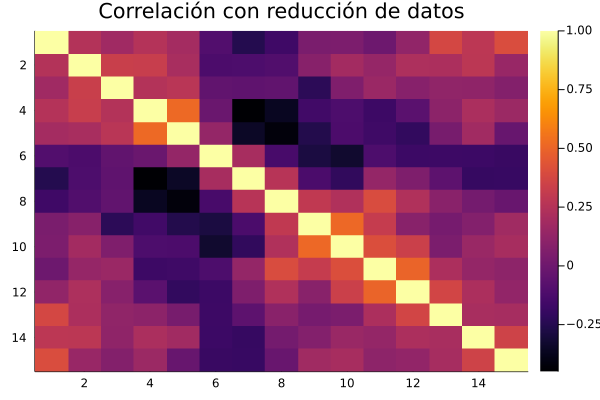

In [8]:
Red = df[!,Not(r"_61")];
V_4 = [ t%4==0 for t in 1 :60 ];
Red = Red[:,V_4];
heatmap(cor(Matrix(Red)),yflip=true, title = "Correlación con reducción de datos")


In [9]:
Ahora volvamos a crear la tabla con el dataframe reducido.

LoadError: syntax: extra token "volvamos" after end of expression

In [10]:
A = Red
for f in names(A)
    print("----------------------------\n")
    B = A[!,Not(f)]
    for t in names(B)
        d = CorrelationTest(A[!,f] , B[!,t]);
        outcome = if pvalue(d)  > 0.05 "No hay evidencia estadística para rechazar H0" else "Rechaza H0" end
        if outcome == "No hay evidencia estadística para rechazar H0" print(f*" "*t*"\n") else   end
        #print(f*" "*t*'\n')        
    end
    A = B
end

----------------------------
C_4 C_24
C_4 C_36
C_4 C_40
C_4 C_44
C_4 C_48
----------------------------
C_8 C_24
C_8 C_28
C_8 C_32
C_8 C_36
C_8 C_44
----------------------------
C_12 C_24
C_12 C_28
C_12 C_32
C_12 C_40
C_12 C_48
C_12 C_52
C_12 C_56
C_12 C_60
----------------------------
C_16 C_24
C_16 C_40
C_16 C_48
C_16 C_52
----------------------------
C_20 C_24
C_20 C_40
C_20 C_52
C_20 C_60
----------------------------
C_24 C_44
----------------------------
C_28 C_36
C_28 C_44
C_28 C_48
C_28 C_52
----------------------------
C_32 C_52
C_32 C_56
C_32 C_60
----------------------------
C_36 C_48
C_36 C_52
C_36 C_56
----------------------------
C_40 C_52
----------------------------
C_44 C_56
C_44 C_60
----------------------------
C_48 C_60
----------------------------
----------------------------
----------------------------


En la siguiente tabla se presenta con 1 los pares de elementos para los cuales no se evidencia correlación. Viendo que en el modelo donde tomamos la característica 12 puede contener al menos nueve varibles no correlacionadas dos a dos. $C_{i}$ con $i \in \{12 , 24, 28, 32, 36, 40, 44, 48, 52, 56, 60\} $ junto con la característica 61 que es la que calsifica los objetos.

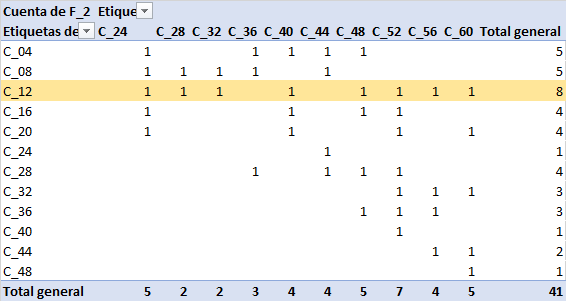

In [11]:
CorrelationTest(df[!,"C_12"] , df[!,"C_24"])

Test for nonzero correlation
----------------------------
Population details:
    parameter of interest:   Correlation
    value under h_0:         0.0
    point estimate:          -0.0512971
    95% confidence interval: (-0.186, 0.08534)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.4618

Details:
    number of observations:          208
    number of conditional variables: 0
    t-statistic:                     -0.737222
    degrees of freedom:              206


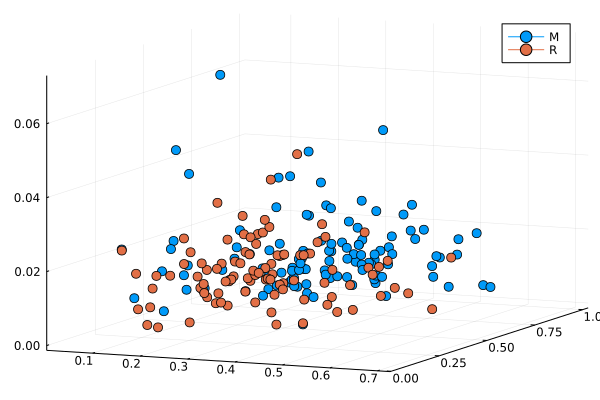

In [12]:
#--------------------------------------using MultivariateStats, RDatasets, StatsPlots
plot3d(df.C_12 , df.C_24 ,df.C_52 ,  group=df.C_61,marker = 5 , line= false)



In [13]:
VoD = [12 , 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 61];
#      1    2   3    4   5   6  7    8   9   10  11  12
DSet = df[:, VoD];

function addColumnInt(data,field,newColumn)
    data[!,field] .= replace.(data[!,field], "M" => "1");
    data[!,field] .= replace.(data[!,field], "R" => "0");
    data[!,newColumn] .= parse.(Int64,data[!,field] );
    data[!,field] .= replace.(data[!,field], "1" => "M");
    data[!,field] .= replace.(data[!,field], "0" => "R");
    return data
end
Dset = addColumnInt(DSet,"C_61","Class");


##  Conjunto de entrenamiento

Teniendo en cuenta que existen 208 ejemplos, se propone dividir el conjunto de la siguiente manera:

|ENTRENAMIENTO|VALIDACIÓN|PRUEBA|
|:-------:|:-------:|:------:|
| 70% | 15% | 15% |

Esto debido a que no suenta con un volumen amplioo de información. La literatura sugiere que para datos de gran volumen se tome 95% y para validaciòn y prueba se tomen 2.5% respectivamente.

In [14]:
using Lathe.preprocess: TrainTestSplit
train, A = TrainTestSplit(DSet,.70)
val, test = TrainTestSplit(A,.5)
println(size(train))
println(size(test))
println(size(val))

(138, 13)
(41, 13)
(29, 13)


#  3. Modelos

## Logistic Regression

In [15]:
fm = @formula( Class ~ C_12 + C_24 +C_28 + C_32 + C_36 + C_40 + C_44 + C_48 + C_52 + C_56 + C_60)
logit = glm(fm, train, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Class ~ 1 + C_12 + C_24 + C_28 + C_32 + C_36 + C_40 + C_44 + C_48 + C_52 + C_56 + C_60

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   -2.45384      0.88224   -2.78    0.0054   -4.183     -0.724685
C_12           3.51636      1.1346     3.10    0.0019    1.29258    5.74013
C_24           1.00947      0.642274   1.57    0.1160   -0.249366   2.2683
C_28          -0.0159905    0.588854  -0.03    0.9783   -1.17012    1.13814
C_32          -0.886763     0.719535  -1.23    0.2178   -2.29703    0.523499
C_36          -1.44132      0.691102  -2.09    0.0370   -2.79586   -0

In [16]:
prediction = predict(logit,test)

41-element Vector{Union{Missing, Float64}}:
 0.8065166138062451
 0.17320200751127457
 0.31619575673472267
 0.7660930634156479
 0.36516563274161284
 0.693103052438671
 0.41030763828520633
 0.5005462725449144
 0.32835852076207295
 0.05592864056220522
 0.9948321455568458
 0.404295271393519
 0.7142221407588318
 ⋮
 0.9984020524332007
 0.991106779046869
 0.6863846260075133
 0.7430383113493672
 0.32240205996271337
 0.9400444898756523
 0.8941980566366703
 0.9997103570335025
 0.9986662548434145
 0.9998620691202939
 0.7946916483922726
 0.9490957014247487

In [21]:
prediction_class = [if x < 0.5 0 else 1 end for x in prediction];
prediction_df = DataFrame(y_actual = test.Class , y_predicted = prediction_class, prob_predicted = prediction);
prediction_df.correctly_classified = prediction_df.y_actual .== prediction_df.y_predicted;

In [22]:
accuaracy = mean(prediction_df.correctly_classified)

0.6341463414634146

In [23]:
confusion_matrix = MLBase.roc(prediction_df.y_actual, prediction_df.y_predicted)

ROCNums{Int64}
  p = 20
  n = 21
  tp = 16
  tn = 10
  fp = 11
  fn = 4


## SVM

In [36]:
using  LIBSVM: svmtrain as  svmt
using  LIBSVM: svmpredict as  svmp

In [60]:
X = Matrix(train[:, 1:11])'
X_test = Matrix(test[:, 1:11])'
y = train.Class;
y_test = test.Class;

In [62]:
model = svmt(X,y);

In [63]:
ŷ, decision_values = svmp(model, X_test);

In [71]:
print("Accuracy: "* string(mean(ŷ .== y_test) * 100))

Accuracy: 51.21951219512195

## Decision Tree

In [89]:
using DecisionTree: build_tree
using DecisionTree: prune_tree
using DecisionTree: print_tree
using DecisionTree: apply_tree
using DecisionTree: nfoldCV_tree

In [78]:
X = convert(Array,train[:, 1:11]);
X_test = convert(Array,test[:, 1:11]);
y = convert(Array,train.Class);
y_test = convert(Array,test.Class);

In [79]:
model = build_tree(y, X)

Decision Tree
Leaves: 19
Depth:  7

In [80]:
model = prune_tree(model, 0.9)

Decision Tree
Leaves: 18
Depth:  7

In [81]:
print_tree(model,5)

Feature 1, Threshold 0.2244
L-> Feature 10, Threshold 0.0098
    L-> Feature 5, Threshold 0.43374999999999997
        L-> Feature 11, Threshold 0.00135
            L-> 1 : 2/2
            R-> Feature 7, Threshold 0.1658
                L-> 0 : 12/12
                R-> 
        R-> 0 : 20/20
    R-> Feature 1, Threshold 0.12714999999999999
        L-> Feature 8, Threshold 0.18030000000000002
            L-> 0 : 6/6
            R-> 1 : 1/1
        R-> Feature 9, Threshold 0.004200000000000001
            L-> 0 : 1/1
            R-> 1 : 8/8
R-> Feature 9, Threshold 0.0093
    L-> Feature 11, Threshold 0.0052
        L-> 1 : 10/11
        R-> Feature 10, Threshold 0.00975
            L-> 0 : 11/11
            R-> Feature 8, Threshold 0.04795
                L-> 0 : 2/2
                R-> 1 : 6/6
    R-> Feature 6, Threshold 0.38195
        L-> 1 : 36/36
        R-> Feature 10, Threshold 0.009049999999999999
            L-> 1 : 10/10
            R-> Feature 7, Threshold 0.3992
           

In [94]:
ŷ=apply_tree(model,X_test);

In [96]:
print("Accuracy: "* string(mean(ŷ .== y_test) * 100));

Accuracy: 60.97560975609756

##  k-Nearest Neighbors


In [102]:
using Distances
using NearestNeighbors

In [127]:
X = convert(Array,train[:, 1:11]);
X_test = convert(Array,test[:, 1:11]);
y = convert(Array,train.Class)';
y_test = convert(Array,test.Class)';

In [108]:
kdtree = KDTree(X');
k = 16;

In [123]:
index_knn, distances = knn(kdtree, X_test', k, true);
output = [index_knn distances];

In [134]:
index_knn_matrix = hcat(index_knn...)
index_knn_matrix_t = permutedims(index_knn_matrix)
knn_classes = y[index_knn_matrix_t];
ŷ = [argmax(countmap(knn_classes[i, :]))  for i in 1:length(y_test) ];
accuracy = mean(ŷ .== y_test)

0.4991076740035693

#  3. Conclusión
Se aplicaron varios modelos para el conjunto de datos propuesto. Es necesario aclarar que no se realizaron ajuste de hiperparámetros ni tampoco se estableció alguna otra forma de ajuste sobre los datos noramlización o estandarización.  se obtienen los siguiente resultados de _Accuaracy_.

|Logistic Regression|SVM|Decission Tree |kNN|
|:-------:|:-------:|:------:|:------:|
| 63.41% |51.21% | 60.97% |49.91% |